In [1]:
import torch_geometric
import torch
from torch_geometric.nn.pool import knn_graph, knn
import numpy as np
import swyft

import torch
from torch.nn import Linear, Parameter
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree

import numpy as np
import torch
from torch import nn
import torch
import time
#import unet

import swyft
import pylab as plt
import scipy.stats.distributions as dist
from astropy.visualization import make_lupton_rgb

import pylab as plt

/home/cweniger/.pyenv/versions/3.10.11/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def padding(x, n_full, dim = 0):
    """Pads a tensor in the first dimension"""
    size = list(x.shape)
    n = size[dim]
    size[dim] = n_full
    size = tuple(size)
    #size = (n_full, *x.shape[1:])
    if isinstance(x, torch.Tensor):
        z = torch.zeros(*size, dtype = x.dtype, device = x.device)
    else:
        z = np.zeros(size, dtype = x.dtype)
    if dim == 0:
        z[:n] = x
    elif dim == 1:
        z[:,:n] = x
    else:
        crash
    return z, n

In [3]:
def batch(points, edge_index, n_points, n_edges, num_output_points = None):
    # points length: n_max_points * n_batch
    # nums: number of actual points per sample
    # ptr: turns into pointer for point sample boundaries
    n_points = torch.tensor(n_points)
    points = torch.tensor(points)
    edge_index = torch.tensor(edge_index)
    n_edges = torch.tensor(n_edges)
    ptr_edges = torch.arange(0, num_output_points*len(points), num_output_points)
    #print(ptr_edges)
    #qwerty
    
    ptr = torch.cat([torch.zeros(1).long().to(n_points.device), torch.cumsum(n_points, 0)])
    points_batch = torch.cat([p[:n] for p, n in zip(points, n_points)])
    #print(edge_index.shape)
    #print(len(n_edges), len(ptr[:-1]), len(ptr_edges[:-1]))
    edge_index_batch1 = torch.cat([e[1, :n]+p for e, n, p in zip(edge_index, n_edges, ptr[:-1])])
    edge_index_batch0 = torch.cat([e[0, :n]+p for e, n, p in zip(edge_index, n_edges, ptr_edges)])
    #print(edge_index_batch0.shape, edge_index_batch1.shape)
    #qwerty
    edge_index_batch = torch.stack([edge_index_batch0, edge_index_batch1])
    #print(edge_index_batch.shape)
    #qwerty

    return points_batch, edge_index_batch, ptr

In [4]:
class GCNConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super().__init__(aggr='mean')  # "Add" aggregation (Step 5).
        self.lin = torch.nn.Sequential(
            torch.nn.Linear(in_channels, 256),
            torch.nn.ReLU(),
            torch.nn.LazyLinear(out_channels)
        )
        self.bias = Parameter(torch.Tensor(out_channels))

#        self.reset_parameters()

    def reset_parameters(self):
        self.lin.reset_parameters()
        self.bias.data.zero_()

    def forward(self, x, edge_index):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]

        # Step 1: Add self-loops to the adjacency matrix.
        #edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Step 2: Linearly transform node feature matrix.
        #x = self.lin(x)

        # Step 3: Compute normalization.
        #row, col = edge_index
        #deg = degree(col, x.size(0), dtype=x.dtype)
        #deg_inv_sqrt = deg.pow(-0.5)
        #deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        #norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        # Step 4-5: Start propagating messages.
        row, col = edge_index*1.
        edge_index[0] = col
        edge_index[1] = row
        #print(row.max(), col.max(), x.shape)
        #qwerty
        out = self.propagate(edge_index, x=x, size=(len(x), len(x)*123))#, norm=norm)
        qwerty

        # Step 6: Apply a final bias vector.
        out += self.bias

        return out

    def message(self, x_j, x_i):
        # x_j has shape [E, out_channels]
        m_j = x_j[:,:1]
        r_ji = x_j[:,1:] - x_i[:,1:]
        d = torch.norm(r_ji, dim = 1)
        return m_j

        ## Step 4: Normalize node features.
        return norm.view(-1, 1) * x_j

In [5]:
class Simulator(swyft.Simulator):
    def __init__(self, bounds = None, Npix = 64, sigma = 0.1):
        super().__init__()
        self.transform_samples = swyft.to_numpy32
        self.theta_sampler = swyft.RectBoundSampler([dist.uniform(4., 0.1)])
        self.bounds = bounds
        self.Npix = Npix
        self.powersampler = swyft.utils.PowerSpectrumSampler(Npix)
        self.target = self.get_target()
        
    def sample_delta(self, theta):
        if self.bounds is not None:
            i = np.random.randint(len(self.bounds))
            return torch.tensor(self.bounds[i])
        else:
            return self.powersampler.sample(lambda k: 1e6*3*(k/0.5)**-theta[0])

    def get_points(self, mu):
        n = self.Npix
        x = torch.linspace(-1, 1, n)
        dx = x[1] - x[0]
        X, Y = torch.meshgrid((x, x), indexing = 'xy')
        idx = torch.multinomial(mu.flatten(), 1000)
        points = torch.stack([X.flatten()[idx], Y.flatten()[idx]], dim = 1)
        points = points + torch.randn(points.shape)*dx
        return padding(points, 1000)

    def get_target(self):
        n = self.Npix
        x = torch.linspace(-1, 1, n)
        X, Y = torch.meshgrid((x, x), indexing = 'xy')
        target = torch.stack([X.flatten(), Y.flatten()], dim = 1)
        return target

    def get_knn(self, points):
        edge_index = knn(torch.tensor(points), self.target, 5).numpy()
        #print(edge_index.shape)
        #print(edge_index[0].max(), edge_index[1].max())
        return padding(edge_index, self.Npix**2*5, dim = 1)

    #def get_knn(self, points):
    #    edge_index = knn_graph(torch.tensor(points), 5).numpy()
    #    #print(edge_index.shape)
    #    return padding(edge_index, 5000, dim = 1)
                
    def build(self, graph):
        theta = graph.node("theta", self.theta_sampler)
        delta = graph.node("delta", self.sample_delta, theta)
        rho = graph.node("rho", lambda delta: torch.exp(delta/3), delta)
        points, n_points = graph.node(["points", "n_points"], self.get_points, rho)
        edge_index, n_edges = graph.node(["edge_index", "n_edges"], lambda points, n_points: self.get_knn(points[:n_points]), points, n_points)


In [10]:
bounds = None
sim = Simulator(bounds = bounds)
sample0 = sim.sample()

/tmp/ipykernel_3692578/3173200366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = knn(torch.tensor(points), self.target, 5).numpy()


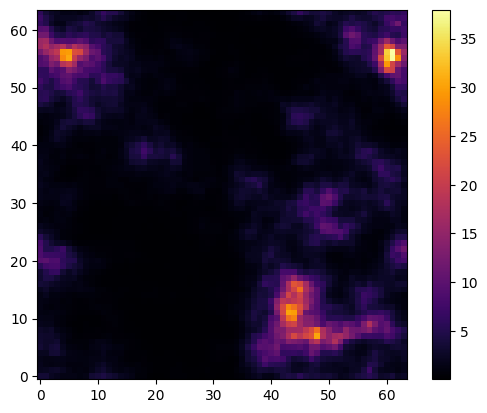

In [11]:
rho = sample0['rho']
plt.imshow(rho, cmap = 'inferno', origin = 'lower')
plt.colorbar()
#print(sample['edge_index'].shape)

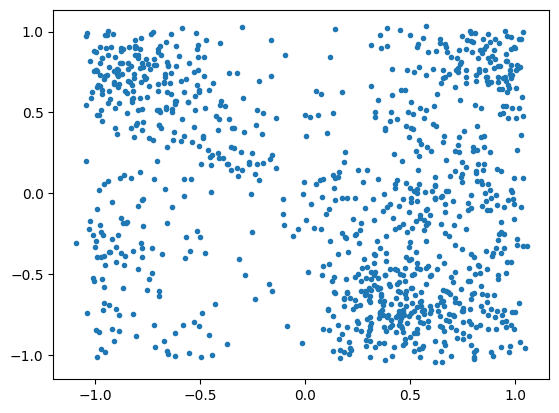

In [12]:
points = sample0['points']
plt.scatter(points[:,0], points[:,1], marker='.')

/tmp/ipykernel_3692578/3173200366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = knn(torch.tensor(points), self.target, 5).numpy()


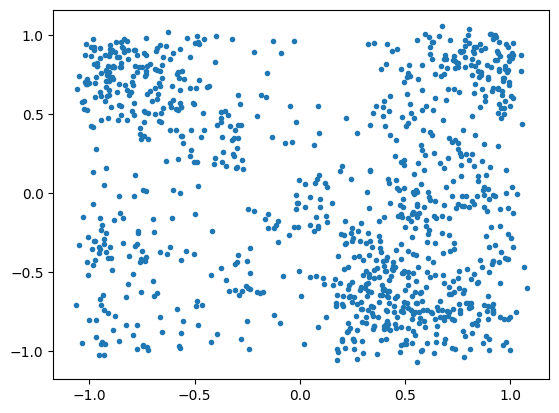

In [100]:
sim = Simulator(bounds = bounds)
points = sim.sample()['points']
plt.scatter(points[:,0], points[:,1], marker='.')

In [76]:
sim = Simulator(bounds = bounds)
samples = sim.sample(1_000)

  0%|                                                                                                                 | 0/1000 [00:00<?, ?it/s]/tmp/ipykernel_3692578/3173200366.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = knn(torch.tensor(points), self.target, 5).numpy()
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 365.18it/s]


In [77]:
class GCNConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super().__init__(aggr='mean')  # "Add" aggregation (Step 5).
        self.lin = torch.nn.Sequential(
            torch.nn.Linear(in_channels, 256),
            torch.nn.ReLU(),
            torch.nn.LazyLinear(out_channels)
        )
        self.bias = Parameter(torch.Tensor(out_channels))

#        self.reset_parameters()

    def reset_parameters(self):
        self.lin.reset_parameters()
        self.bias.data.zero_()

    def forward(self, x, g, edge_index, n_batch):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]

        # Step 1: Add self-loops to the adjacency matrix.
        #edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Step 2: Linearly transform node feature matrix.
        #x = self.lin(x)

        # Step 3: Compute normalization.
        #row, col = edge_index
        #deg = degree(col, x.size(0), dtype=x.dtype)
        #deg_inv_sqrt = deg.pow(-0.5)
        #deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        #norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        # Step 4-5: Start propagating messages.
        row, col = edge_index*1.
        edge_index[0] = col
        edge_index[1] = row
        #print(row.max(), col.max(), x.shape)
        #qwerty
        
        out = self.propagate(edge_index, size=(len(x), 4096*n_batch), x=x, g=g.repeat(n_batch, 1))#, norm=norm)
        #print(out.shape)
        #qwerty

        # Step 6: Apply a final bias vector.
        out += self.bias

        return out

    def message(self, x_j, g_i):
        #print(x_j.shape)
        d = torch.norm(x_j - g_i, dim = 1)
        return d.view(-1, 1)
    #    print(x_j, x_i)
    #    qweqoiwueqowiueqoiwue
    #    # x_j has shape [E, out_channels]
    #    m_j = x_j[:,:1]
    #    r_ji = x_j[:,1:] - x_i[:,1:]
    #    d = torch.norm(r_ji, dim = 1)
    #    return m_j##

        ### Step 4: Normalize node features.
        #return norm.view(-1, 1) * x_j

In [78]:
class Network(swyft.SwyftModule):
    def __init__(self):
        super().__init__()
        self.logratios = swyft.LogRatioEstimator_Gaussian_Autoregressive_X_module_based(64*64, 'delta')
        self.g = GCNConv(3, 1)

    def embed(self, points, edge_index, n_points, n_edges):
        x, ei, ptr = batch(points, edge_index, n_points, n_edges, num_output_points=64*64)
        nb = len(points)
        g = sim.target.to(points.device)
        return self.g(x, g, ei, nb).view(nb, 64, 64, -1)[..., 0]

    def forward(self, A, B):
        points = A['points']
        edge_index = A['edge_index']
        n_points = A['n_points']
        n_edges = A['n_edges']
        outA = self.embed(points, edge_index, n_points, n_edges)

        points = B['points']
        edge_index = B['edge_index']
        n_points = B['n_points']
        n_edges = B['n_edges']
        outB = self.embed(points, edge_index, n_points, n_edges)
        
        zB = B['delta']
        logratios = self.logratios(outA.view(-1, 64*64), outB.view(-1, 64*64), zB.view(-1, 64*64))
        return logratios

In [79]:
trainer = swyft.SwyftTrainer(accelerator = 'cuda', devices=1, max_epochs = 15, precision = 64)
dm = swyft.SwyftDataModule(samples, fractions = [0.8, 0.2, 0.0], num_workers = 0, batch_size = 32)
network = Network()
trainer.fit(network, dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                                                     | Params
---------------------------------------------------------------------------------------
0 | logratios | LogRatioEstimator_Gaussian_Autoregressive_X_module_based | 0     
1 | g         | GCNConv                                                  | 1.0 K 
---------------------------------------------------------------------------------------
1.0 K     Traina

/tmp/ipykernel_3692578/1178892397.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  n_points = torch.tensor(n_points)
/tmp/ipykernel_3692578/1178892397.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  points = torch.tensor(points)
/tmp/ipykernel_3692578/1178892397.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edge_index)
/tmp/ipykernel_3692578/1178892397.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_g

Epoch 0:  78%|██████████████████████████████████████████████████████████▌                | 25/32 [00:00<00:00, 28.15it/s, loss=-329, v_num=126]
Validation: 0it [00:00, ?it/s]
Epoch 1:  78%|██████████████████████████████████████████████             | 25/32 [00:00<00:00, 33.97it/s, loss=-380, v_num=126, val_loss=-379.]
Validation: 0it [00:00, ?it/s]
Epoch 2:  78%|██████████████████████████████████████████████             | 25/32 [00:00<00:00, 36.96it/s, loss=-395, v_num=126, val_loss=-398.]
Validation: 0it [00:00, ?it/s]
Epoch 3:  78%|██████████████████████████████████████████████             | 25/32 [00:00<00:00, 36.53it/s, loss=-400, v_num=126, val_loss=-402.]
Validation: 0it [00:00, ?it/s]
Epoch 4:  78%|██████████████████████████████████████████████             | 25/32 [00:00<00:00, 34.42it/s, loss=-402, v_num=126, val_loss=-402.]
Validation: 0it [00:00, ?it/s]
Epoch 5:  78%|██████████████████████████████████████████████             | 25/32 [00:00<00:00, 29.37it/s, loss=-403, v_num=12

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 00015: reducing learning rate of group 0 to 9.0000e-05.
Epoch 14: 100%|██████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 31.71it/s, loss=-403, v_num=126, val_loss=-399.]


In [86]:
GAMMA = 1
network.cpu()
y = network.embed(torch.tensor(sample0['points']).unsqueeze(0), torch.tensor(sample0['edge_index']).unsqueeze(0), torch.tensor(sample0['n_points']).unsqueeze(0), torch.tensor(sample0['n_edges']).unsqueeze(0))[0].flatten()
prior = sim.powersampler.get_prior_Q_factors(lambda k: 1e6*3*(k/0.5)**-4)
prior = (prior[0], prior[1].cuda(), prior[2])
network.cuda()
y = y.cuda()
x0 = network.logratios.get_MAP(y, prior, gamma = GAMMA).view(64, 64).cpu().detach()

/tmp/ipykernel_3692578/1178892397.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  n_points = torch.tensor(n_points)
/tmp/ipykernel_3692578/1178892397.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  points = torch.tensor(points)
/tmp/ipykernel_3692578/1178892397.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edge_index)
/tmp/ipykernel_3692578/1178892397.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_g

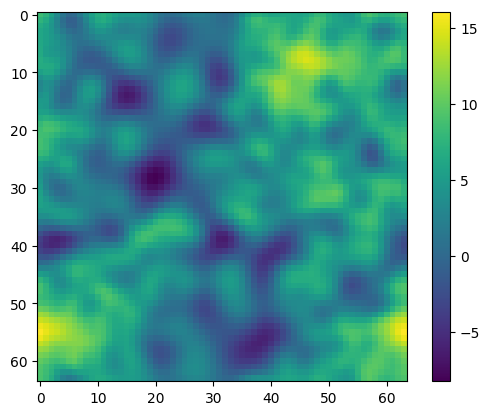

In [87]:
plt.imshow(x0)
plt.colorbar()

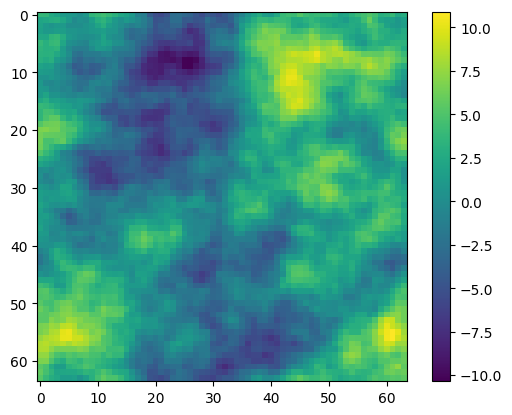

In [88]:
plt.imshow(sample0['delta'])
plt.colorbar()

In [89]:
draws = network.logratios.get_noise_samples_GEDA(4, prior, steps = 300, reset = True, gamma = GAMMA)
bounds = [(x0.view(64, 64).cpu().detach() + draws[i].view(64, 64).cpu()).numpy() for i in range(len(draws))]
bounds = np.array(bounds)

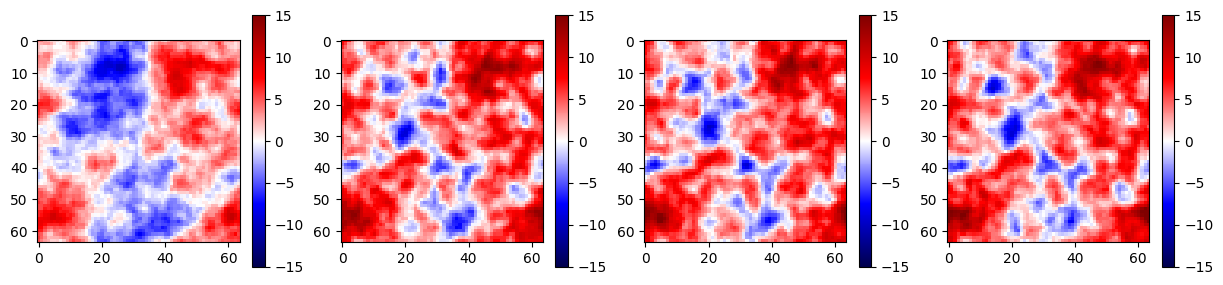

In [90]:
v = 15
plt.figure(figsize = (15, 15))
for i in range(4):
    plt.subplot(4, 4, i+1)
#    plt.imshow(x0.view(NPIX, NPIX).cpu().detach() + draws[i].view(NPIX, NPIX).cpu(), cmap = 'seismic', vmin = -v, vmax = v)
    if i == 0:
        plt.imshow(sample0['delta'], cmap = 'seismic', vmin = -v, vmax = v)
    else:
        plt.imshow(bounds[i], vmin = -v, vmax = v, cmap = 'seismic')
    plt.colorbar()